<a href="https://colab.research.google.com/github/MiiN1136/Depression-Classification-Model/blob/main/Depression_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

In [2]:
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [3]:
data = pd.read_csv(path+"/student_depression_dataset.csv")

In [4]:
data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [5]:
data.info() #0 nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [6]:
data.loc[data.duplicated()] #0 duplicates

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


##cleaning **sleep duration** column

In [7]:
data['Sleep Duration'].unique()

array(["'5-6 hours'", "'Less than 5 hours'", "'7-8 hours'",
       "'More than 8 hours'", 'Others'], dtype=object)

In [8]:
data['Sleep Duration'].value_counts()['Others']

np.int64(18)

In [9]:
sleep_duration = data['Sleep Duration'].unique()
sleep_duration
sleep_durationn = [re.sub(r'[^0-9]', ' ', string).strip() if string != "Others" else '0' for string in sleep_duration]
print(sleep_durationn)

['5 6', '5', '7 8', '8', '0']


In [10]:
test1 = [sleep_durationn[i].split() if not pd.isna(sleep_durationn[i]) else sleep_durationn[i] for i in range(len(sleep_durationn))]

In [11]:
sleep_durationn = [[float(x) for x in t] for t in test1]

In [12]:
sleep_durationn

[[5.0, 6.0], [5.0], [7.0, 8.0], [8.0], [0.0]]

##updating the dataframe with cleaned sleep duration values

###transforming **sleep duration** column into a numerical one

used the average of the given ranges:
* for `less than 5 hours` : [2 : 5]
* for `more than 8 hours` : [8 : 11]

In [13]:
data['Sleep Duration'].value_counts()

,count
Sleep Duration,
'Less than 5 hours',8310
'7-8 hours',7346
'5-6 hours',6183
'More than 8 hours',6044
Others,18


In [14]:
dict_sleep = {"'5-6 hours'": (5+6)/2,
              "'Less than 5 hours'" : (5+2)/2,
              "'7-8 hours'": (7+8)/2,
              "'More than 8 hours'" : (8+11)/2,
              "Others": np.nan #to drop later on (only 0.06% of the data)
              }

In [15]:
data['Sleep Duration'] = data['Sleep Duration'].map(dict_sleep)

In [16]:
data.dropna(inplace=True)

In [17]:
data['Sleep Duration'].value_counts()

,count
Sleep Duration,
3.5,8310
7.5,7346
5.5,6183
9.5,6044


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27883 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27883 non-null  int64  
 1   Gender                                 27883 non-null  object 
 2   Age                                    27883 non-null  float64
 3   City                                   27883 non-null  object 
 4   Profession                             27883 non-null  object 
 5   Academic Pressure                      27883 non-null  float64
 6   Work Pressure                          27883 non-null  float64
 7   CGPA                                   27883 non-null  float64
 8   Study Satisfaction                     27883 non-null  float64
 9   Job Satisfaction                       27883 non-null  float64
 10  Sleep Duration                         27883 non-null  float64
 11  Dietary

##One hot encoding

In [19]:
data['Have you ever had suicidal thoughts ?'] = [1 if item == "Yes" else 0 for item in data['Have you ever had suicidal thoughts ?']]

In [20]:
data['Family History of Mental Illness'] = [0 if item == 'No' else 1 for item in data['Family History of Mental Illness']]

In [21]:
data['Gender'] = [0 if item == 'Male' else 1 for item in data['Gender']]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27883 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27883 non-null  int64  
 1   Gender                                 27883 non-null  int64  
 2   Age                                    27883 non-null  float64
 3   City                                   27883 non-null  object 
 4   Profession                             27883 non-null  object 
 5   Academic Pressure                      27883 non-null  float64
 6   Work Pressure                          27883 non-null  float64
 7   CGPA                                   27883 non-null  float64
 8   Study Satisfaction                     27883 non-null  float64
 9   Job Satisfaction                       27883 non-null  float64
 10  Sleep Duration                         27883 non-null  float64
 11  Dietary

##Ordinal encoding

In [23]:
data['Dietary Habits'].unique()

array(['Healthy', 'Moderate', 'Unhealthy', 'Others'], dtype=object)

In [24]:
dietary_habits = data['Dietary Habits'].tolist() #checking data distribution
dietary_habits.count('Healthy'), dietary_habits.count("Moderate"), dietary_habits.count('Unhealthy'), dietary_habits.count('Others')

(7648, 9914, 10309, 12)

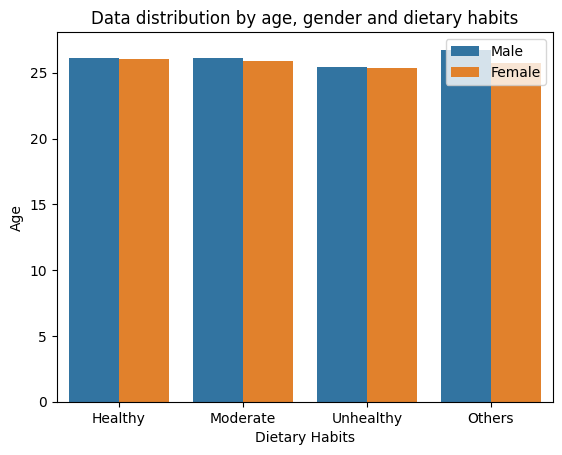

In [25]:
sns.barplot(data, x='Dietary Habits', y='Age', hue='Gender', errorbar=None)
plt.title("Data distribution by age, gender and dietary habits")
plt.legend(labels= ['Male', 'Female'])
plt.show()

In [26]:
data['Dietary Habits'] = [3 if item == 'Healthy' else 2 if item == 'Moderate' else 1 if item == 'Unhealthy' else 0 for item in data['Dietary Habits']]

In [27]:
data.info(5)

<class 'pandas.core.frame.DataFrame'>
Index: 27883 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27883 non-null  int64  
 1   Gender                                 27883 non-null  int64  
 2   Age                                    27883 non-null  float64
 3   City                                   27883 non-null  object 
 4   Profession                             27883 non-null  object 
 5   Academic Pressure                      27883 non-null  float64
 6   Work Pressure                          27883 non-null  float64
 7   CGPA                                   27883 non-null  float64
 8   Study Satisfaction                     27883 non-null  float64
 9   Job Satisfaction                       27883 non-null  float64
 10  Sleep Duration                         27883 non-null  float64
 11  Dietary

## cleaning the *Degree* column
Ordinal encoding was applied with reference to this order :
* doctoral & medical > master's degree > bachelor's degree > school-level

In [28]:
data['Degree'].unique()

array(['B.Pharm', 'BSc', 'BA', 'BCA', 'M.Tech', 'PhD', "'Class 12'",
       'B.Ed', 'LLB', 'BE', 'M.Ed', 'MSc', 'BHM', 'M.Pharm', 'MCA', 'MA',
       'B.Com', 'MD', 'MBA', 'MBBS', 'M.Com', 'B.Arch', 'LLM', 'B.Tech',
       'BBA', 'ME', 'MHM', 'Others'], dtype=object)

In [29]:
degree= data['Degree']

In [30]:
data['Degree'] = [4 if item in ['Phd', 'MBSS', 'MD']
                  else 3 if item in ['M.Tech', 'M.Ed', 'MSc',' M.Pharm', 'MCA', 'MA', 'MBA','M.Com', 'ME', 'MHM', 'LLM']
                  else 2 if item in ['B.Pharm', 'BSc', 'BA', 'BCA','B.Ed','LLB','BE','BHM','B.Bom', 'B.Arch', 'B.Tech', 'BBA']
                  else 1
                  for item in degree]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27883 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27883 non-null  int64  
 1   Gender                                 27883 non-null  int64  
 2   Age                                    27883 non-null  float64
 3   City                                   27883 non-null  object 
 4   Profession                             27883 non-null  object 
 5   Academic Pressure                      27883 non-null  float64
 6   Work Pressure                          27883 non-null  float64
 7   CGPA                                   27883 non-null  float64
 8   Study Satisfaction                     27883 non-null  float64
 9   Job Satisfaction                       27883 non-null  float64
 10  Sleep Duration                         27883 non-null  float64
 11  Dietary

## Removing professions other than *Student*

In [32]:
profession_other_than_student = data[data['Profession'] != 'Student']
print(f"Different professions : {profession_other_than_student['Profession'].unique()}\n\nCount per profession : {profession_other_than_student['Profession'].value_counts()} \n\nTotal: {profession_other_than_student['Profession'].count()}")

Different professions : ["'Civil Engineer'" 'Architect' "'UX/UI Designer'" "'Digital Marketer'"
 "'Content Writer'" "'Educational Consultant'" 'Teacher' 'Manager' 'Chef'
 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']

Count per profession : Profession
Architect                   8
Teacher                     6
'Digital Marketer'          3
Chef                        2
'Content Writer'            2
Pharmacist                  2
Doctor                      2
'UX/UI Designer'            1
'Civil Engineer'            1
Manager                     1
'Educational Consultant'    1
Lawyer                      1
Entrepreneur                1
Name: count, dtype: int64 

Total: 31


In [33]:
total = len(data)
(31 / total) *100 #% of professions other than student <<< 5% of total => minority to be removed

0.1111788544991572

In [34]:
not_student_index = data[data['Profession'] != 'Student'].index

In [35]:
for i in not_student_index:
  data = data.drop(i)  #dropping the columns that have a profession other than 'Student'

In [36]:
data.value_counts('Profession')

,count
Profession,
Student,27852


##dropping the 'Profession' column
Decided to drop the profession column since it's a dummy constant (has all values == 'Student')

In [37]:
data = data.drop('Profession', axis=1)

In [38]:
data = data.reset_index(drop=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27852 entries, 0 to 27851
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27852 non-null  int64  
 1   Gender                                 27852 non-null  int64  
 2   Age                                    27852 non-null  float64
 3   City                                   27852 non-null  object 
 4   Academic Pressure                      27852 non-null  float64
 5   Work Pressure                          27852 non-null  float64
 6   CGPA                                   27852 non-null  float64
 7   Study Satisfaction                     27852 non-null  float64
 8   Job Satisfaction                       27852 non-null  float64
 9   Sleep Duration                         27852 non-null  float64
 10  Dietary Habits                         27852 non-null  int64  
 11  De

## *City* column cleaning

###This column has unstructured data that needs to be either
* removed : useless data such as people names (e.g `Vaanya`) or degrees (e.g `ME`, `M.Com`)
* corrected : incorrectly introduced city names (e.g `Khaziabad` instead of `Ghaziabad`)

In [40]:
data['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', 'Saanvi', 'M.Tech', 'Bhavna', "'Less Delhi'",
       'City', '3.0', "'Less than 5 Kalyan'", 'Mira', 'Harsha', 'Vaanya',
       'Gaurav', 'Harsh', 'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com',
       'Nalyan', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad'], dtype=object)

In [41]:
bad_values = ['Saanvi', 'M.Tech', 'Bhavna', "'Less Delhi'", 'City', '3.0',
              "'Less than 5 Kalyan'", 'Harsha', 'Vaanya', 'Gaurav', 'Harsh',
              'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com', 'Mihir', 'Nalini', 'Nandini']

data.loc[data['City'].isin(bad_values), 'City'] = np.nan

In [42]:
data.loc[data['City'] == 'Mira', 'City'] = 'Mira-Bhayandar'

In [43]:
data.loc[data['City'] == 'Nalyan', 'City'] ='Kalyan'

In [44]:
data.loc[data['City'] == 'Khaziabad', 'City'] = 'Ghaziabad'

In [45]:
data['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', nan, 'Mira-Bhayandar'], dtype=object)

### adding longi w lati

used `geopy`

In [46]:
data['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', nan, 'Mira-Bhayandar'], dtype=object)

In [47]:
geolocator = Nominatim(user_agent="api_agentV1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [48]:
unique_cities = data['City'].dropna().unique()

In [49]:
city_lat_long ={}

In [50]:
for city in unique_cities:
    try:
        query = f"{city}, India"
        location = geocode(query)
        if location:
            city_lat_long[city] = (location.latitude, location.longitude)
        else:
            city_lat_long[city] = (None, None)
            print(f"Not Found: {city}")

    except Exception as e:
        print(f"Error for {city}: {e}")
        city_lat_long[city] = (None, None)

In [51]:
coordinates = data['City'].map(city_lat_long)

In [52]:
coordinates.dropna(inplace=True)

In [53]:
data.dropna(inplace=True)

In [54]:
lati = [coordinates.tolist()[i][0] for i in range(len(data))]

In [55]:
longi = [coordinates.tolist()[i][1] for i in range(len(data))]

In [56]:
data.insert(3, "Latitude", value=lati)
data.insert(4, "Longitude" , value=longi)

In [57]:
data.drop(columns=['City'], inplace=True)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27829 entries, 0 to 27851
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27829 non-null  int64  
 1   Gender                                 27829 non-null  int64  
 2   Age                                    27829 non-null  float64
 3   Latitude                               27829 non-null  float64
 4   Longitude                              27829 non-null  float64
 5   Academic Pressure                      27829 non-null  float64
 6   Work Pressure                          27829 non-null  float64
 7   CGPA                                   27829 non-null  float64
 8   Study Satisfaction                     27829 non-null  float64
 9   Job Satisfaction                       27829 non-null  float64
 10  Sleep Duration                         27829 non-null  float64
 11  Dietary

##dropping the *job satisfaction* and *work pressure* columns

We've observed that only a small percentage of the remaining students have meaningful work pressure and job satifaction values, that is why we've decided to drop these 2 cols

In [59]:
job_satisfaction = data[data['Job Satisfaction'] != 0].count().sum()
work_pressure = data[data['Work Pressure'] != 0].count().sum()
job_satisfaction, work_pressure

(np.int64(144), np.int64(54))

In [60]:
#calculating the percentage
job_satisfaction_precentage = (job_satisfaction.item() / 27870)*100
work_pressure_percentage = (work_pressure.item() / 27870)*100
print(f"Only {round(job_satisfaction_precentage,2)}% of students have filled the job satisfaction column \nOnly {round(work_pressure_percentage,2)}% of students have filled the work pressure column ")

Only 0.52% of students have filled the job satisfaction column 
Only 0.19% of students have filled the work pressure column 


In [61]:
data = data.drop('Job Satisfaction', axis = 1)

In [62]:
data = data.drop('Work Pressure', axis =1)

##'Financial Stress' column cleaning

In [63]:
data['Financial Stress'].value_counts()

,count
Financial Stress,
5.0,6695
4.0,5767
3.0,5212
1.0,5104
2.0,5048
?,3


In [64]:
index = data.loc[data['Financial Stress'] == '?', 'Financial Stress'].index

In [65]:
index

Index([4446, 13573, 19232], dtype='int64')

In [66]:
data.drop(index=index, inplace=True)

In [67]:
data.reset_index(drop=True, inplace=True)

In [68]:
financial_stress = data['Financial Stress']

In [69]:
data['Financial Stress'] = [float(financial_stress[i]) if str(financial_stress[i]) else data['Financial Stress'] for i in range(len(data))]

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27826 entries, 0 to 27825
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27826 non-null  int64  
 1   Gender                                 27826 non-null  int64  
 2   Age                                    27826 non-null  float64
 3   Latitude                               27826 non-null  float64
 4   Longitude                              27826 non-null  float64
 5   Academic Pressure                      27826 non-null  float64
 6   CGPA                                   27826 non-null  float64
 7   Study Satisfaction                     27826 non-null  float64
 8   Sleep Duration                         27826 non-null  float64
 9   Dietary Habits                         27826 non-null  int64  
 10  Degree                                 27826 non-null  int64  
 11  Ha

In [71]:
data.head()

,id,Gender,Age,Latitude,Longitude,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,17.693553,83.292130,5.0,8.97,2.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,12.976794,77.590082,2.0,5.90,5.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,34.074744,74.820444,3.0,7.03,5.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,25.335649,83.007629,3.0,5.59,2.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,26.915458,75.818982,4.0,8.13,3.0,5.5,2,3,1,1.0,1.0,0,0


##Discovering relationships between features and the label 'Depression'

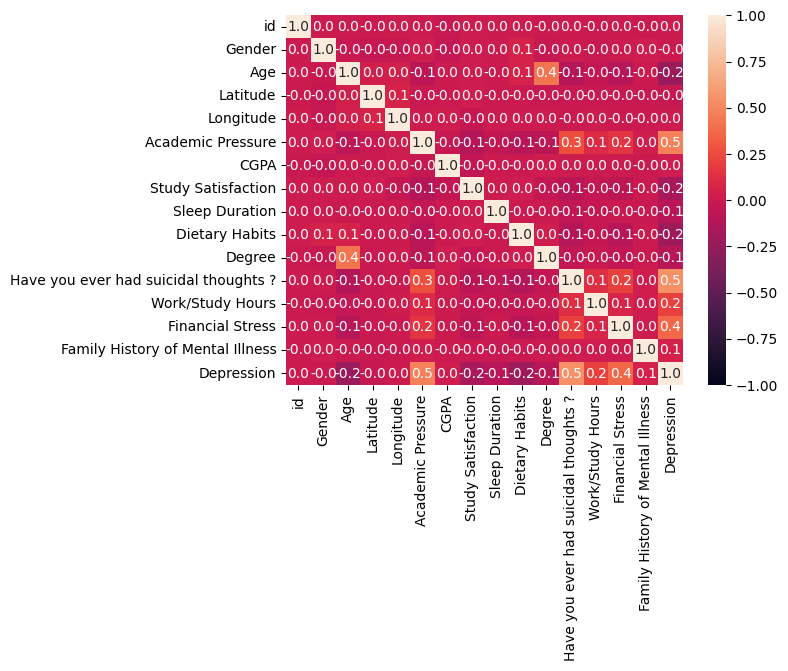

In [72]:
sns.heatmap(data=data.corr('pearson'), vmin=-1.0, vmax=1.0, fmt=".1f", annot=True)
plt.show()

##Transforming clean data into tensors
We're going to use 4 features :
* f0 = have you ever had suicidal thoughts
* f1 = academic pressure
* f2 = financial stress
* f3 = work/study hours

In [73]:
#setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [74]:
x_df = data.loc[:, ['Have you ever had suicidal thoughts ?', 'Academic Pressure', 'Financial Stress']]
y_df = data.iloc[:, 15]
x_df.shape, y_df.shape

((27826, 3), (27826,))

In [75]:
x_np = np.array(x_df, dtype=np.float32)
y_np = np.array(y_df, dtype=np.float32)

In [76]:
X = torch.from_numpy(x_np)
y = torch.from_numpy(y_np)

In [77]:
X.shape, y.shape

(torch.Size([27826, 3]), torch.Size([27826]))

# Binary Classification

## data splitting

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [79]:
X_train.shape, y_train.shape

(torch.Size([22260, 3]), torch.Size([22260]))

## accuracy helper function

In [80]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum()
  acc = correct.item() / len(y_pred) * 100
  return acc

## building the model

In [81]:
class Depressed_or_notClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features = 3, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features = 512, out_features =1)
    )

  def forward(self, x):
    return self.layers(x)

###Using Adam as optimizer

In [88]:
torch.manual_seed(42)
model_v1 = Depressed_or_notClassificationModel()

In [89]:
bce = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.01, weight_decay=1e-4)

In [90]:
sigmoid = nn.Sigmoid()

In [91]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
model_v1 = model_v1.to(device)

### Training

In [92]:
epochs = 200

epoch_count = []
train_loss_count = []
test_loss_count = []
accuracy_count = []

for epoch in range(epochs):
  model_v1.train()

  y_pred_logits = model_v1(X_train)
  y_pred = torch.round(sigmoid(y_pred_logits))

  loss = bce(y_pred_logits.squeeze(1), y_train)

  train_accuracy = accuracy_fn(y_train, y_pred.squeeze(1))

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  with torch.inference_mode():
    y_pred_test_logits = model_v1(X_test)
    y_pred_test = torch.round(sigmoid(y_pred_test_logits))

    test_loss = bce(y_pred_test_logits.squeeze(1), y_test)

    test_accuracy = accuracy_fn(y_test, y_pred_test.squeeze(1))

  #tracking
  if epoch%10 == 0:
    epoch_count.append(epoch)
    train_loss_count.append(loss)
    test_loss_count.append(test_loss)
    accuracy_count.append([round(train_accuracy,4), round(test_accuracy,4)])



In [93]:
for i in range(len(epoch_count)) :
  print(f"epoch : {epoch_count[i]} | train loss : {train_loss_count[i]} | test loss : {test_loss_count[i]} | train accuracy : {accuracy_count[i][0]} | test accuracy : {accuracy_count[i][1]}")

epoch : 0 | train loss : 0.6718653440475464 | test loss : 1.0295395851135254 | train accuracy : 58.6433 | test accuracy : 58.0489
epoch : 10 | train loss : 0.5249139070510864 | test loss : 0.4598228633403778 | train accuracy : 79.2138 | test accuracy : 81.5307
epoch : 20 | train loss : 0.44686925411224365 | test loss : 0.4154449701309204 | train accuracy : 78.9173 | test accuracy : 81.4589
epoch : 30 | train loss : 0.41184091567993164 | test loss : 0.3981205224990845 | train accuracy : 81.7385 | test accuracy : 82.1595
epoch : 40 | train loss : 0.40353596210479736 | test loss : 0.3950531482696533 | train accuracy : 82.0979 | test accuracy : 82.8602
epoch : 50 | train loss : 0.3996284008026123 | test loss : 0.3891533315181732 | train accuracy : 82.3854 | test accuracy : 83.2914
epoch : 60 | train loss : 0.3985471725463867 | test loss : 0.3896280825138092 | train accuracy : 82.2731 | test accuracy : 83.2016
epoch : 70 | train loss : 0.39829665422439575 | test loss : 0.38914239406585693 |

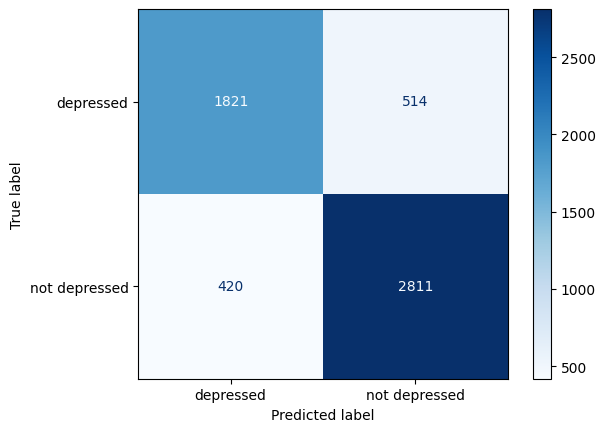

In [94]:
variables = confusion_matrix(y_true= y_test.cpu(), y_pred=y_pred_test.cpu())
ConfusionMatrixDisplay(variables, display_labels = ('depressed','not depressed')).plot(cmap='Blues')
plt.show()

In [95]:
precision = 1781/(1781+375)
print(f"Precision : {round(precision*100, 2)}%")

Precision : 82.61%


In [96]:
recall = 1781 / (1781+566)
print(f"Recall : {round(recall*100, 2)}%")

Recall : 75.88%


In [97]:
f1_score = 2 * ((recall*precision)/(recall+precision))
print(f"F1-score : {round(f1_score*100, 2)}%")

F1-score : 79.1%


##saving the model

In [100]:
path = 'depression_classification_model_V1.pth'

In [99]:
torch.save({
    'model_state_dict' : model_v1.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
}, path )